<div>
    <div style="float:left;width:50%;text-align:center">
        <h1>pyGIMLi Tutorial @ Transform 2021</h1>
        <div>
<table style="border-collapse:collapse;border-color:#ccc;border-spacing:0" class="tg"><thead><tr><th style="background-color:#f0f0f0;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:middle;word-break:normal"></th><th style="background-color:#f0f0f0;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:middle;word-break:normal">Info</th></tr></thead><tbody><tr><td style="background-color:#f9f9f9;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:middle;word-break:normal">When</td><td style="background-color:#f9f9f9;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:middle;word-break:normal">Live: Monday, April 19 • 8:00 - 10:00 UTC</td></tr><tr><td style="background-color:#fff;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:middle;word-break:normal">Slack (Q&amp;A)</td><td style="background-color:#fff;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;text-decoration:underline;vertical-align:top;word-break:normal"><a href="https://softwareunderground.org/">Software Underground</a> channel <a href="https://swung.slack.com/archives/C01T5V5S9EV">#t21-mon-pygimli</a></td></tr><tr><td style="background-color:#f9f9f9;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:middle;word-break:normal">Recording</td><td style="background-color:#f9f9f9;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;text-decoration:underline;vertical-align:top;word-break:normal"><a href="https://www.youtube.com/watch?v=w3pu0H3dXe8&t=6068">https://www.youtube.com/watch?v=w3pu0H3dXe8&t=6068</a></td></tr><tr><td style="background-color:#fff;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:middle;word-break:normal">pyGIMLi documentation</td><td style="background-color:#fff;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;text-decoration:underline;vertical-align:top;word-break:normal"><a href="https://www.pygimli.org/documentation.html">https://www.pygimli.org/documentation.html</a></td></tr></tbody></table>
        </div>
    </div>
    <div style="float:right;width:30%">
        <img src="https://www.pygimli.org/_images/pg_logo.png" alt="pyGIMLi logo">
    </div>
</div>

# Inversion with custom forward operators
### Objectives
1. Show how to use an own forward operator along with the pyGIMLi inversion
2. Generate a synthetic model for drone-base CSEM
3. Invert the synthetic data with pyGIMLi

We use a modelling tool called `empymod` from Dieter Werthmüller.
The repository can be found on https://emsig.github.io/

`empymod` provides electromagnetic modelling for 1D VTI media with arbitrary transmitters and sensors in 3D space. For installation we call:
```
conda install -c conda-forge empymod
```
or run `pip install empymod` in the console or in a cell here.

In [1]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-notebook")
%config InlineBackend.figure_format='svg'

In [2]:
import pygimli as pg
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import empymod

First, we define some settings that are to be used. We assume an electric dipole transmitter perpendicular to the x-z place of length `txLen` and magnetic receivers in the air (e.g. on a drone) along a profile line. Date are obtained in frequency domain for a number of frequencies.

In [3]:
# receiver setting
rx = np.arange(50., 501., 50)
ry = np.zeros(rx.size)
# empymod arguments including transmitter
txLen = 400
inpdat = {'src': [0, 0, txLen/2, -txLen/2., 0.1, 0.1], 'strength': 1,  # ground
           'mrec': True, 'rec': [rx, ry, -20, 0, 90],  # Hz air
           # 'mrec': False, 'rec': [rx, ry, 0.1, 90, 0],  # Ey ground
          'srcpts': 11, 'htarg': {'pts_per_dec': -1}, 'verb': 1}
# frequencies
freqs = [10., 20, 50, 100, 200, 500, 1000, 2000., 5000.]  # Hz

We define a function for calling empymod with vectors of resistivity and depth.

In [4]:
def fwd(res, dep):
    """Call empymods function bipole with the above arguments."""
    assert len(res) == len(dep)
    OUT = np.zeros((len(freqs), len(rx)), dtype=np.complex)
    for i, f in enumerate(freqs):
        OUT[i, :] = empymod.bipole(res=np.concatenate(([2e14], res)),
                                   depth=dep, freqtime=f, **inpdat)

    return OUT

Next we create a functon to show the real and imaginary part of the data as image plots.

In [5]:
def showData(A, ax=None, sym=True):
    """Show data as two subplots for real and imaginary part."""
    if ax is None:
        fig, ax = plt.subplots(1, 2)

    if A.ndim == 1: # long vector
        reim = np.reshape(A, (2, -1))
        A = np.reshape(reim[0], (len(freqs), -1)) + \
            np.reshape(reim[1], (len(freqs), -1)) * 1j
 
    norm = clr.NoNorm()
    cmap = "Spectral_r"
    if sym:
        mi = np.min(np.abs(A))
        ma = np.max(np.abs(A))
        norm = clr.SymLogNorm(mi, vmin=-ma, vmax=ma, base=10)#, linscale=mi)
        cmap = 'RdBu_r'

    imr = ax[0].imshow(A.real, norm=norm, cmap=cmap)
    plt.colorbar(imr, ax=ax[0], orientation="horizontal")
    imi = ax[1].imshow(A.imag, norm=norm, cmap=cmap)
    plt.colorbar(imi, ax=ax[1], orientation="horizontal")
    if A.shape[1] == len(rx):
        for a in ax:
            a.xaxis.set_ticks(range(len(rx))[::3])
            a.xaxis.set_ticklabels([str(int(r)) for r in rx][::3])
            a.set_xlabel('x (m)')
            a.yaxis.set_ticks([y for y in range(len(freqs))])
            a.yaxis.set_ticklabels([str(int(f)) for f in freqs])
            a.set_ylabel('f (Hz)')

    ax[0].xaxis.set_ticks([])
    ax[0].set_xlabel('')
    ax[0].set_title("real part")
    ax[1].set_title("imaginary part")
    plt.tight_layout()
    return ax

We now create a synthetic model of a good conductor embedded in a resistive halfspace.

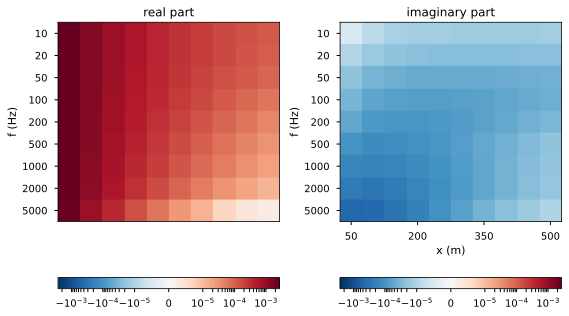

In [6]:
depth = [0, 100, 200]  # m
res = [100, 10, 100]
A0 = fwd(res, depth)
showData(A0);

To use the forward modelling in pyGIMLi, we create a class, derived from the pg modelling base class, and set the `response` and `createStartModel` functions, and init a 1D mesh for an Occam-type inversion. 

In [7]:
class myFwd(pg.Modelling):
    def __init__(self, depth):
        """Initialize the model."""
        self.dep = depth
        self.mesh1d = pg.meshtools.createMesh1D(len(self.dep))
        super().__init__()
        self.setMesh(self.mesh1d)
    
    def response(self, model):
        """Forward response."""
        A = fwd(model, self.dep)
        Avec = A.ravel()
        return np.hstack((Avec.real, Avec.imag))
        
    def createStartModel(self):
        return pg.Vector(len(self.dep)) * 100

We organize the real and imaginary part and add relative error to the data

In [8]:
A0vec = A0.ravel()
data = np.hstack((A0vec.real, A0vec.imag))
# error = np.abs(data) * 0.01 + 0.00001
relativeError = np.ones_like(data) * 0.01
data *= (np.random.randn(len(data)) * relativeError + 1.0)

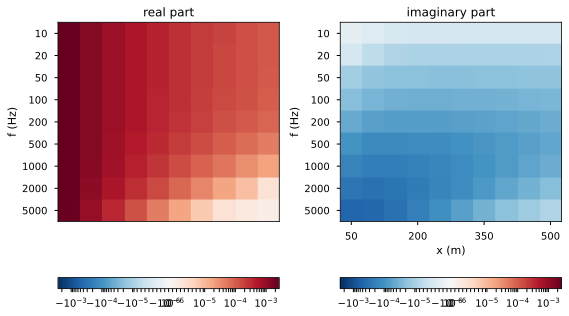

In [9]:
depth_fixed = np.linspace(0., 300., 21)
fop = myFwd(depth_fixed)
resistivity = np.ones_like(depth_fixed) * 100
response = fop.response(resistivity)
showData(response);

We set up the pgGIMLi inversion usng the forward operator created by `myFwd` (fop) using `setForwardOperator`

In [10]:
inv = pg.Inversion()
inv.setForwardOperator(fop)
transModel = pg.trans.TransLog(1) # > 1 Ohmm
inv.transModel = transModel

In [11]:
model = inv.run(data, relativeError, startModel=100, verbose=True)

28/04/21 - 17:37:49 - pyGIMLi - INFO - Startmodel set from given value. 100.0
28/04/21 - 17:37:49 - pyGIMLi - INFO - Starting inversion.


fop: <__main__.myFwd object at 0x7fe2f8720680>
Data transformation: <pgcore._pygimli_.RTransLin object at 0x7fe308308630>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x7fe2f8720270>
min/max (data): -4.7e-04/0.0027
min/max (error): 1.00%/1.00%
min/max (start model): 100/100
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 89.5 (dPhi = 78.51%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 77.91 (dPhi = 13.29%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 68.32 (dPhi = 12.54%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 5 ... chi² = 55.57 (dPhi = 18.84%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 

We plot the model using a dedicated model plotter along with the synthetic model.

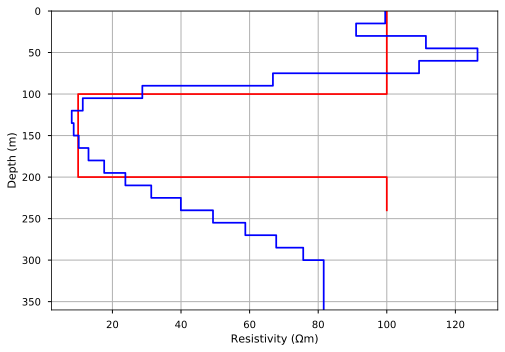

In [12]:
from pygimli.viewer.mpl import drawModel1D
fig, ax = plt.subplots()
drawModel1D(ax, np.diff(depth), res, color="red", label="synthetic")
drawModel1D(ax, np.diff(depth_fixed), model, color="blue", label="inverted")

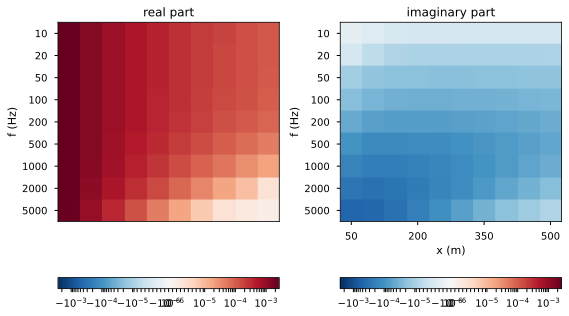

In [13]:
# Plot the model response (to be compared to the data)
showData(response);

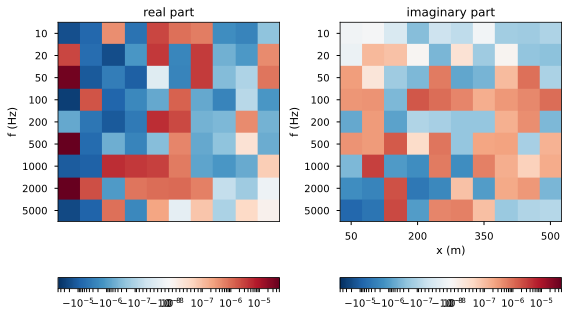

In [14]:
# Plot the misfit
showData(inv.response-data);